In [1]:
# MSS used from screen capture.
from mss import mss
# Sending commands to game.
import pydirectinput

# Googles OCR package used to know when the game ends.
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# OpenCV allows us to do frame processing
import cv2

import numpy as np
from matplotlib import pyplot as plt
import time

# Environment components
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,80,120), dtype=np.uint8)
        self.action_space = Discrete(3)

        with mss() as sct:
            self.mon0 = sct.monitors[0]
            self.mon1 = sct.monitors[1]
            self.mon2 = sct.monitors[2]
            print("Net Display:", self.mon0)
            print("Display 1:  ", self.mon1)
            print("Display 2:  ", self.mon2)

        # Extraction parameters for the game.
        self.cap = mss()
        self.game_location = {'top':self.mon2['top'] + 130, 'left':self.mon2['left'] + 100, 'width':400, 'height':300}
        self.done_location = {'top':self.mon2['top'] + 210, 'left':self.mon2['left'] + 480, 'width':190, 'height':45}

    def step(self, action):
        # 0 = Jump, 1 = Duck, 2 = No Action
        action_map = {0: 'space', 1: 'down', 2: 'no_op'}
        if action != 2:
            pydirectinput.press(action_map[action])
        done, done_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        return new_observation, reward, done, info

    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=self.mon2['top'] + 200, y=self.mon2['left'] + 200)
        pydirectinput.press('space')
        return self.get_observation()

    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) and 0xFF == ord('q'):
            self.close()

    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):
        crop_width, crop_height = 120, 80
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (crop_width, crop_height))
        channel = np.reshape(resized, (1, crop_height, crop_width))
        return channel

        
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done_strings = ["GAME", "GAHE"]
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [3]:
env = WebGame()

Net Display: {'left': 0, 'top': 0, 'width': 3926, 'height': 1440}
Display 1:   {'left': 0, 'top': 0, 'width': 2560, 'height': 1440}
Display 2:   {'left': 2560, 'top': 339, 'width': 1366, 'height': 768}


In [4]:
env.reset()

array([[[33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        ...,
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33]]], dtype=uint8)

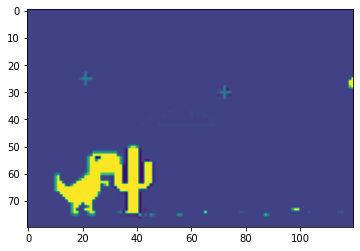

In [5]:
obs = env.get_observation()
# plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))
plt.imshow(env.get_observation()[0])

True


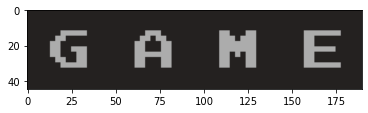

In [6]:
status = env.get_done()
print(status[0])
plt.imshow(status[-1])

In [ ]:
epochs = 10

In [ ]:
for epoch in range(epochs):
    obs = env.reset()
    done = False 
    total_reward = 0  
    while not done:
        obs, reward , done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for epoch {epoch} is {total_reward}')

In [7]:
import os 

from stable_baselines3.common.callbacks import BaseCallback

from stable_baselines3.common import env_checker

In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [9]:
CHECKPOINT_DIR = './Train'
LOG_DIR = './logs/'

In [10]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [11]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [12]:
env = WebGame()

Net Display: {'left': 0, 'top': 0, 'width': 3926, 'height': 1440}
Display 1:   {'left': 0, 'top': 0, 'width': 2560, 'height': 1440}
Display 2:   {'left': 2560, 'top': 339, 'width': 1366, 'height': 768}


In [13]:
model = DQN(
    policy = 'CnnPolicy', 
    env = env, 
    tensorboard_log = LOG_DIR, 
    verbose = 1, 
    buffer_size = 100000, 
    learning_starts = 1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
model.learn(total_timesteps=5000, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 5        |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 12       |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.62     |
|    ep_rew_mean      | 4.62     |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 25       |
|    total_timesteps  | 37       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.17     |
|    ep_rew_mean      | 5.17     |
|    exploration_rate | 0.882    |
| time/               |        

KeyboardInterrupt: 